# Neural net approach

The goal of this notebook is to try using neural nets (in particular the [`tabular` nets from `fastai`](https://docs.fast.ai/tutorial.tabular)). While just straight-up using a NN is somewhat problematic in terms of explainability, my goal is just to see what kind of accuracy we can get. If there's no real improvement over what we're seeing with XGB then there's no point fussing with NNs anymore. If there _is_ an improvement, then we should turn our attention to this.

In [187]:
import pandas as pd
import numpy as np

from utils.data_loader import Dataset

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers.experimental import preprocessing

from sklearn.preprocessing import LabelEncoder

In [188]:
def load_ds(train_or_test='train'):
    if train_or_test == 'train':
        start_date = '2000-01-01'
        end_date = '2015-01-01'
    else:
        start_date = '2015-01-01'
        end_date = '2020-01-01'
        
    ds = Dataset('tf')
    ds.load_games(start_date, end_date)
    ds.add_team_stats(cols=['Avg_Attendance', 'W-L-pct'])
    ds.add_team_pitching_stats(cols=['WHIP', 'ERA'])
    ds.add_pitcher_stats(cols=['WHIP', 'ERA', 'IP']);

    ds.data = ds.data.drop(['home_pitcher', 'away_pitcher', 'date'], axis='columns')
    
    bucketized_cols = ['D', 'home_rest', 'away_rest', 
                   'pitcher_away_IP_offset1game', 'pitcher_home_IP_offset1game',
                  'home_team_season_game_num', 'away_team_season_game_num',
                  'home_W-L-pct_offset1year', 'away_W-L-pct_offset1year']
    embedding_cols = ['home_team', 'away_team', 'Y', 'M']
    numeric_cols = list(set(ds.data.columns) - set(bucketized_cols).union(set(embedding_cols)))
    numeric_cols.remove('home_win')

    # Column groups used for making crossed feature columns
    date_cols = ['Y', 'M', 'D']
    home_cols = [c for c in ds.data.columns if c.startswith('home_')]

    home_cols.remove('home_win')
    away_cols = [c for c in ds.data.columns if c.startswith('away_')]

    home_pitching_cols = [c for c in ds.data.columns if c.startswith('pitcher_home_')]
    home_pitching_cols.extend(['home_WHIP_offset1year', 'home_ERA_offset1year'])
    away_pitching_cols = [c for c in ds.data.columns if c.startswith('pitcher_away_')]
    away_pitching_cols.extend(['away_WHIP_offset1year', 'away_ERA_offset1year'])
    
    assert len(bucketized_cols) + len(embedding_cols) + len(numeric_cols) + 1 == len(ds.data.columns)
    
    for c in ds.data.columns:
        if ds.data[c].isin([-np.inf, np.inf]).sum() > 0:
            ds.data[c] = ds.data[c].replace([-np.inf, np.inf], None)
        if ds.data[c].isna().sum() > 0:
            med = ds.data[c].median()
            ds.data[c] = ds.data[c].fillna(med)
            
    le = LabelEncoder()
    ds.data['away_team'] = le.fit_transform(ds.data['away_team'])
    ds.data['home_team'] = le.transform(ds.data['home_team'])
    
    for c in embedding_cols:
        ds.data[c] = ds.data[c].astype(int)
        
    assert ds.data.isna().sum().sum() == 0
    
    y = ds.data.pop('home_win')
    y = y.astype(int)
    X = ds.data
    
    ds = tf.data.Dataset.from_tensor_slices((dict(X), y)).batch(128)
    return ds

In [189]:
train_ds = load_ds('train')
test_ds = load_ds('test')

## Preparing columns

In [190]:
# feature_cols = []

# for c in numeric_cols:
#     feature_cols.append(tf.feature_column.numeric_column(c))
    
# for c in bucketized_cols:
#     cuts = list(np.linspace(ds.data[c].min()-1, ds.data[c].max()+1, 10))
#     numeric_c = tf.feature_column.numeric_column(c)
#     feature_cols.append(tf.feature_column.bucketized_column(numeric_c, boundaries=cuts))
    
# for c in embedding_cols:
#     embedded_c = tf.feature_column.categorical_column_with_vocabulary_list(c, X[c].unique())
#     feature_cols.append(tf.feature_column.embedding_column(embedded_c, dimension=10))
    
# feature_layer = tf.keras.layers.DenseFeatures(feature_cols)

## Preprocessing layers

In [191]:
def get_normalization_layer(name, dataset):
    # Create a Normalization layer for our feature.
    normalizer = preprocessing.Normalization()

    # Prepare a Dataset that only yields our feature.
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the statistics of the data.
    normalizer.adapt(feature_ds)

    return normalizer

In [253]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
    # Create a StringLookup layer which will turn strings into integer indices
    if dtype == 'string':
        index = preprocessing.StringLookup(max_tokens=max_tokens)
    else:
        index = preprocessing.IntegerLookup(max_values=max_tokens)

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the set of possible values and assign them a fixed integer index.
    index.adapt(feature_ds)

    # Create a Discretization for our integer indices.
    encoder = preprocessing.CategoryEncoding(max_tokens=index.vocab_size())

    # Prepare a Dataset that only yields our feature.
    feature_ds = feature_ds.map(index)

    # Learn the space of possible indices.
    encoder.adapt(feature_ds)

    # Apply one-hot encoding to our indices. The lambda function captures the
    # layer so we can use them, or include them in the functional model later.
    return lambda feature: encoder(index(feature))

In [254]:
def prep_columns(dataset, embedding_dims=[10]):
    cont_inputs = []
    cat_inputs = []
    encoded_cont_features = []
    encoded_cat_features = []
    if isinstance(embedding_dims, int):
        embedding_dims = [embedding_dim] * len(embedding_cols)
    assert len(embedding_dims) == len(embedding_cols), 'embedding_dims must be an integer or a list with the same length as embedding_cols'

    # Numeric features.
    for header in numeric_cols + bucketized_cols:
        numeric_col = tf.keras.Input(shape=(1,), name=header)
        normalization_layer = get_normalization_layer(header, dataset)
        encoded_numeric_col = normalization_layer(numeric_col)
        encoded_numeric_col = tf.keras.layers.Dropout(0.1)(encoded_numeric_col)
        cont_inputs.append(numeric_col)
        encoded_cont_features.append(encoded_numeric_col)

    # Categorical features encoded as ints.
    for i, header in enumerate(embedding_cols):
        categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='int64')
        encoding_layer = get_category_encoding_layer(header, dataset, 
                                                     dtype='int', 
                                                     max_tokens=100)
        encoded_categorical_col = encoding_layer(categorical_col)
        encoded_categorical_col = tf.keras.layers.Embedding(100, embedding_dims[i], name=f'{header}_embedding')(encoded_categorical_col)
        encoded_categorical_col = tf.keras.layers.Flatten()(encoded_categorical_col)
        cat_inputs.append(categorical_col)
        encoded_cat_features.append(encoded_categorical_col)
        
    all_inputs = cont_inputs + cat_inputs
        
    return all_inputs, encoded_cont_features, encoded_cat_features

In [255]:
all_inputs, encoded_cont_features, encoded_cat_features = prep_columns(train_ds, 10)

AttributeError: 'CategoryEncoding' object has no attribute 'get_vocabulary'

## Creating the model

In [245]:
x = tf.keras.layers.concatenate(encoded_cat_features + encoded_cont_features)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(all_inputs, output)
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [246]:
# model = tf.keras.Sequential([
#   feature_layer,
#   Dense(256, activation='relu'),
#   Dense(256, activation='relu'),
#   Dropout(.1),
#   Dense(1)
# ])

# model.compile(optimizer='adam',
#               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               metrics=['accuracy'])

In [247]:
model.fit(train_ds, epochs=20, validation_data=test_ds)

Epoch 1/20
266/266 [==============================] - 5s 12ms/step - loss: 0.8545 - accuracy: 0.5495 - val_loss: 0.6512 - val_accuracy: 0.5685
Epoch 2/20
266/266 [==============================] - 2s 9ms/step - loss: 0.6881 - accuracy: 0.5611 - val_loss: 0.6483 - val_accuracy: 0.5818
Epoch 3/20
266/266 [==============================] - 3s 10ms/step - loss: 0.6547 - accuracy: 0.5703 - val_loss: 0.6475 - val_accuracy: 0.5902
Epoch 4/20
266/266 [==============================] - 2s 9ms/step - loss: 0.6480 - accuracy: 0.5738 - val_loss: 0.6482 - val_accuracy: 0.5935
Epoch 5/20
266/266 [==============================] - 2s 9ms/step - loss: 0.6442 - accuracy: 0.5827 - val_loss: 0.6487 - val_accuracy: 0.5939
Epoch 6/20
266/266 [==============================] - 2s 9ms/step - loss: 0.6451 - accuracy: 0.5850 - val_loss: 0.6485 - val_accuracy: 0.5924
Epoch 7/20
266/266 [==============================] - 2s 9ms/step - loss: 0.6437 - accuracy: 0.5849 - val_loss: 0.6484 - val_accuracy: 0.5979
Epoc

In [248]:
loss, acc = model.evaluate(test_ds)
print(f'Test accuracy = {100*acc:.2f}%')

95/95 [==============================] - 1s 5ms/step - loss: 0.6608 - accuracy: 0.6087
Test accuracy = 60.87%


## Word embeddings

Get the team embeddings from the embedding layers. Following [this tutorial](https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk).

In [249]:
home_team_weights = model.get_layer('home_team_embedding').get_weights()[0]

In [251]:
home_team_weights.shape

(100, 10)

## fastai

In [96]:
from fastai.tabular.all import *

In [100]:
ds = Dataset('tf')
ds.load_games()
ds.add_team_stats(cols=['Avg_Attendance', 'W-L-pct'])
ds.add_team_pitching_stats(cols=['WHIP', 'ERA'])
ds.add_pitcher_stats(cols=['WHIP', 'ERA', 'IP']);

ds.data = ds.data.drop(['home_pitcher', 'away_pitcher', 'date'], axis='columns')

for c in ds.data.columns:
    if ds.data[c].isin([-np.inf, np.inf]).sum() > 0:
        ds.data[c] = ds.data[c].replace([-np.inf, np.inf], None)
    if ds.data[c].isna().sum() > 0:
        med = ds.data[c].median()
        ds.data[c] = ds.data[c].fillna(med)
            
le = LabelEncoder()
ds.data['away_team'] = le.fit_transform(ds.data['away_team'])
ds.data['home_team'] = le.transform(ds.data['home_team'])

for c in embedding_cols:
    ds.data[c] = ds.data[c].astype(int)

assert ds.data.isna().sum().sum() == 0

In [129]:
cat_cols = list(ds.data.loc[:,ds.data.nunique().sort_values() < 100].columns)
cont_cols = list(set(ds.data.columns) - set(cat_cols))
cat_cols.remove('home_win')

In [130]:
# bucketized_cols = ['D', 'home_rest', 'away_rest', 
#                    'pitcher_away_IP_offset1game', 'pitcher_home_IP_offset1game',
#                   'home_team_season_game_num', 'away_team_season_game_num',
#                   'home_W-L-pct_offset1year', 'away_W-L-pct_offset1year']
# embedding_cols = ['home_team', 'away_team', 'Y', 'M']
# numeric_cols = list(set(ds.data.columns) - set(bucketized_cols).union(set(embedding_cols)))
# numeric_cols.remove('home_win')

In [131]:
# cont_names = bucketized_cols + numeric_cols

In [132]:
dls = TabularDataLoaders.from_df(ds.data, y_names='home_win', 
                                 cat_names=cat_cols, cont_names=cont_cols,
                                procs=[Categorify, FillMissing, Normalize])

In [133]:
learn = tabular_learner(dls, metrics=accuracy, loss_func=BCEWithLogitsLossFlat())

SuggestedLRs(lr_min=0.0006309573538601399, lr_steep=0.9120108485221863)

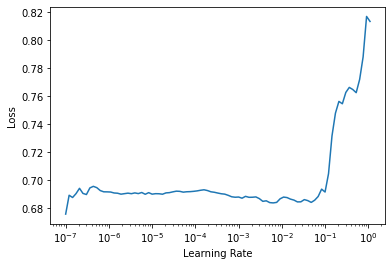

In [134]:
learn.lr_find()

In [136]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.561172,0.681562,0.467755,00:07
1,0.555013,0.694990,0.467755,00:07
2,0.538123,0.704179,0.467755,00:07
3,0.523331,0.709097,0.467755,00:07
4,0.519009,0.710337,0.467755,00:07


In [138]:
preds, targs = learn.get_preds()

In [149]:
for p, t in zip(preds.numpy()[:10], targs.numpy()[:10]):
    print(f'{p[0]:.3f} -> {t[0]}')

0.776 -> 1.0
0.908 -> 1.0
0.260 -> 0.0
0.532 -> 1.0
0.454 -> 1.0
0.265 -> 0.0
0.216 -> 1.0
0.927 -> 0.0
0.393 -> 0.0
0.721 -> 1.0
